# Introduction
This is an analysis of spatial outreach in the multiplex structure. The spatial outreach of a node in a multiplex is defined as follows. Let $\ell(i,j)$ be the length of the shortest path between node $i$ and node $j$ measured according to some chosen edge weights. We define the set $S(r) = \{j \; | \; \ell(i,j) < r  \}$ as the set of nodes reachable from $i$ for prescribed cost $r$. Let $P(r)$ be the convex hull of $S(r)$, and $A(r)$ the area of $P(r)$. The spatial outreach of node $i$ for cost $r$ is then $\sqrt{A(r)}$. As defined, spatial outreach has units of length, and is a measure of the mean radius of the convex hull of $S(r)$.

# 0. Preparation

In [1]:
% matplotlib inline

# homebrewed modules
from metro import io
from metro import utility
from metro import analysis
from metro import viz
from metro import assignment

# other modules
import networkx as nx
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
import numpy as np

In [2]:
multi = io.read_multi() # read the prepared multiplex from 2_multiplex/

# 1. Global Analysis of Spatial Outreach

The purpose of this section is to analyze the global distribution of spatial outreach across the Riyadh network. We'll compute spatial outreach without and with the metro in place, and for varying metro speeds. 

Throughout this first section, we'll analyze the reachable area for an agent who can travel for 20 minutes, assuming congestion on the street network. 

In [3]:
## Parameters of analysis
cost = 20 # assume 20 minute travel time
edge_weight = 'congested_time_m' # measures cost incurred through travel
betas = [1.0, .9, 0.5, 0.1, .01] # metro speeds we'll analyse, .5 means metro runs twice as fast
cols = ['layer', 'outreach_no_metro', 'id'] # will be the columns of the data frame we use for analysis

Compute spatial outreach assuming no metro use

In [4]:
analysis.spatial_outreach(multi, 
                          node_layer = 'taz',
                          thru_layers = ['streets'],
                          weight = edge_weight,
                          cost = cost,
                          attrname = 'outreach_no_metro')

converting to igraph
computing distance matrix
computing outreach


Compute spatial outreach with metro use. We'll start with normal metro speeds, and progressively increase the speed of the metro using beta as a scaling factor. 

In [5]:
for beta in betas: # beta defined with other parameters
    multi.scale_edge_attribute(layer = 'metro', 
                               attribute = edge_weight, 
                               beta = beta)
    
    analysis.spatial_outreach(multi, 
                          node_layer = 'taz',
                          thru_layers = ['streets', 'metro'],
                          weight = edge_weight,
                          cost = cost,
                          attrname = 'outreach_metro_' + str(beta))
    
    multi.scale_edge_attribute(layer = 'metro', 
                               attribute = edge_weight, 
                               beta = 1. / beta) # scale back, ready for next time
    
    cols.append('outreach_metro_' + str(beta)) # add attribute name to list of columns

converting to igraph
computing distance matrix
computing outreach
converting to igraph
computing distance matrix
computing outreach
converting to igraph
computing distance matrix
computing outreach
converting to igraph
computing distance matrix
computing outreach
converting to igraph
computing distance matrix
computing outreach


Ok, now let's extract the results into a data frame...

In [ ]:
df = utility.nodes_2_df(multi.G, col_names = cols) # extract the named attributes as data frame columns
df = df[df['layer'] == 'taz'] # since only taz nodes have spatial outreach computed
del df['layer'] # don't need this any more

...and plot! 

/Users/phil/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


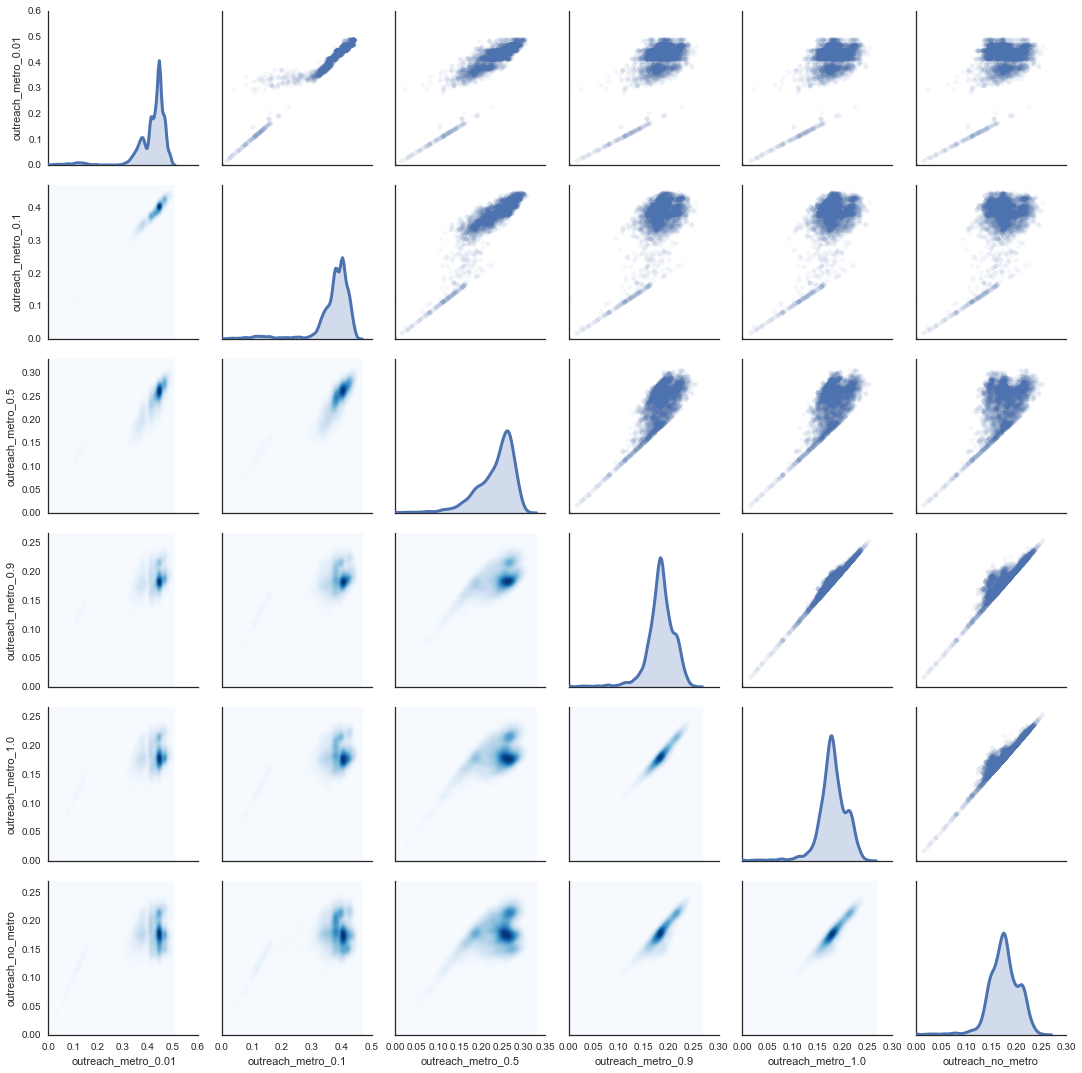

In [7]:
sns.set_style("white")
g = sns.PairGrid(df)
g = g.map_upper(plt.scatter, alpha = .05)
g = g.map_lower(sns.kdeplot, 
                n_levels=100, 
                cmap="Blues", 
                shade = True)
g = g.map_diag(sns.kdeplot, 
               shade = True, 
               lw=3, 
               legend=False)
g.set(ylim=(0, None), xlim = (0, None))

We observe some separation in the plots between groups, which PC conjectures is based on their proximity for the metro. A small number of TAZs are more than 20 minutes away from the metro, so increasing $\beta$ has no impact on their spatial outreach. 

## Summary statistics

Mean outreach

In [8]:
print df.mean()

outreach_metro_0.01    0.414491
outreach_metro_0.1     0.371811
outreach_metro_0.5     0.234122
outreach_metro_0.9     0.183994
outreach_metro_1.0     0.180890
outreach_no_metro      0.176329
dtype: float64


Spread of outreach

In [9]:
print df.std()

outreach_metro_0.01    0.069462
outreach_metro_0.1     0.067192
outreach_metro_0.5     0.044457
outreach_metro_0.9     0.028093
outreach_metro_1.0     0.028336
outreach_no_metro      0.029779
dtype: float64


Gini coefficients

In [10]:
for col in df:
    if col != 'id':
        print col + '  --  ' + str(analysis.gini_coeff(df[col]))

outreach_metro_0.01  --  0.0720648232039
outreach_metro_0.1  --  0.0790794864714
outreach_metro_0.5  --  0.0996537462792
outreach_metro_0.9  --  0.07848442809
outreach_metro_1.0  --  0.0816230806068
outreach_no_metro  --  0.0909055994664


Ok, but what if we want the mean weighted by the population at that node? We can compute this using the od dict. Overall, the results are comparable to the unweighted averages. 

In [11]:
od = assignment.od_dict(multi.G, 
                        '1_data/taz_od/0_1.txt',
                        pivot = False)

od = od.groupby('o').sum() # collapsing gives total flow out of each node, i.e. the estimated population
df = df.merge(od, left_on = ['id'], right_index = True)
del df['id']

computing od dictionary
OD dict computed in 0.3 m


In [12]:
for col in df: 
    print col + ' --  ' + str(np.average(df[col], weights = df['flow_norm']))

outreach_metro_0.01 --  0.406370679235
outreach_metro_0.1 --  0.363623071141
outreach_metro_0.5 --  0.223524796688
outreach_metro_0.9 --  0.178725554561
outreach_metro_1.0 --  0.175867405787
outreach_no_metro --  0.171849774465
flow_norm --  1642.84989453


In [15]:
del df['flow_norm']

## Spatial distribution of outreach

Let's visualize how the outreach distribution changes with increasing metro speed. 

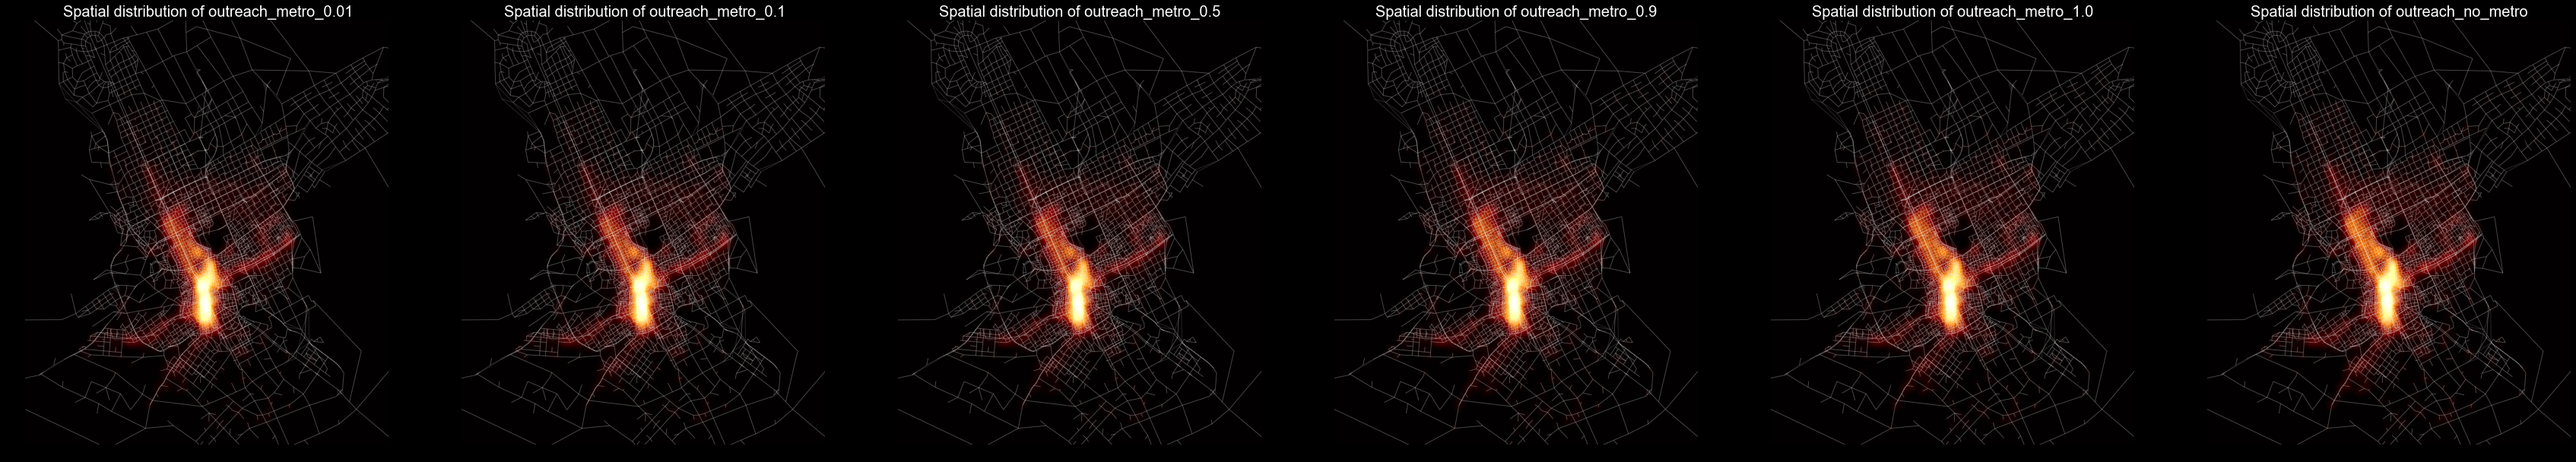

In [16]:
G = multi.as_graph()

n = len(df.columns.values.tolist())
fig = plt.figure(figsize = (n*10,10))

i = 1

for col in df: 
    ax = fig.add_subplot(1,n,i)
    i += 1

    viz.spatial_plot(G, 
                     attr = col, 
                     ax = ax, 
                     layer = 'taz')
                     
    xlim = (46.4167, 47.0167)
    ylim = (24.4333, 25.0333)
    ax.set(xlim = xlim, ylim = ylim)
    
    plt.title('Spatial distribution of ' + col, 
              color = 'w', 
              fontsize = 20)
    
fig.set_facecolor("#000000")

Interestingly, the distribution doesn't seem to change much qualitatively. We know from above, however, that the outreaches for low $\beta$ are significantly higher. 

# 2. Visualizing individual mobility

Now we'd like to simply visualize the mobility of an individual on the network, letting the metro speed vary. This isn't a systematic analysis, just a simple set of plots to help us see in a more tangible way how the metro might impact individuals. We'll let the metro speed vary. First, two simple utility functions. 

In [19]:
def plot_ego(ego, color):
    ego.position = {n : (ego.node[n]['lon'], ego.node[n]['lat']) for n in ego}
    nx.draw(ego, ego.position,
    edge_color = color, 
    edge_size = 20,
    node_color = color,
    linewidth = 0,
    node_size = 0,
    alpha = .3,
    with_labels = False,
    arrows = False)

def RGBToHTMLColor(rgb_tuple):
    """ convert an (R, G, B) tuple to #RRGGBB """
    hexcolor = '#%02x%02x%02x' % rgb_tuple
    return hexcolor

Ok, now let's run the plot. 

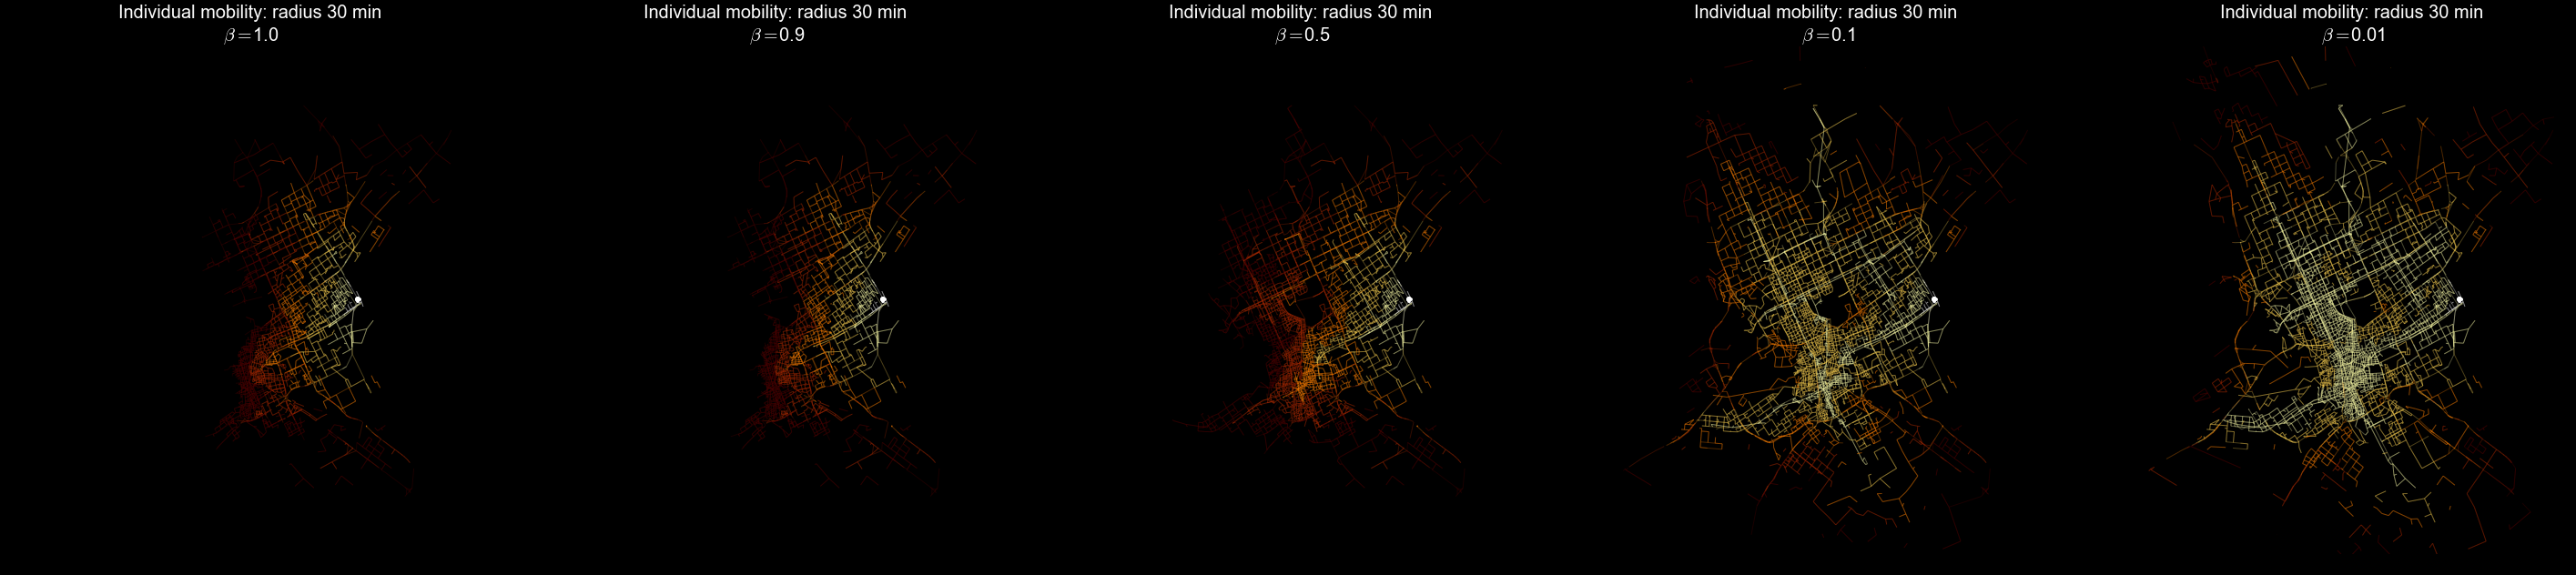

In [20]:
node = random.choice(G.node.keys()) # pick a random node at which to start

fig = plt.figure(figsize = (len(betas) * 10,10)) # initialize empty figure

i = 1 # keeps track of which subplot we are on
for beta in betas: 
    ax = fig.add_subplot(1,len(betas),i)   
    i += 1

    multi.scale_edge_attribute(layer = 'metro', 
                               attribute = 'congested_time_m', 
                               beta = beta)

    total = nx.DiGraph() # nodes we've already seen
    radii = [5, 10, 15, 20, 25, 30]
    plt.title('Individual mobility: radius ' + str(max(radii)) + ' min \n ' + r'$\beta = $' + str(beta) , 
              color = 'w', 
              fontsize = 20)
    
    for radius in radii: # main plotting loop
        # get a color from a colormap for this layer of the plot
        x = pylab.cm.afmhot(1 - (radius*1.0 - min(radii)) / max(radii)) 
        x = tuple([y * 255 for y in list(x)])
        # compute the ego graph for this radius and remove nodes we've already seen
        ego = nx.ego_graph(G, node, radius = radius, distance = 'congested_time_m')
        ego.remove_nodes_from(n for n in ego.copy() if n in total) # remove from ego all the nodes we've already seen
        total = nx.union(total, ego) # seen them now
        
        plot_ego(ego, RGBToHTMLColor(x[:3]))
    
    xlim = (46.4167, 47.0167)
    ylim = (24.4333, 25.0333)
    ax = plt.gca() # current axis to set lims
    ax.set(xlim = xlim, ylim = ylim)

    plt.plot(G.node[node]['lon'], G.node[node]['lat'], 'wo')
    fig.set_facecolor("#000000") # black backgrounds are cool, like bowties
    multi.scale_edge_attribute(layer = 'metro', 
                               attribute = 'congested_time_m', 
                               beta = 1.0/beta)

Lighter colors indicate that the area in question is reachable in less time. We observe that an individual's mobility substantially increases as $\beta$ decreases. Though initially the metro plays relatively little role in the individual's mobility, as $\beta$ crosses $0.5$ we begin to observe the contours of the reachable set structured around the metro lines. 